In [10]:
pip install --upgrade google-cloud-bigquery

     |████████████████████████████████| 163kB 9.4MB/s 
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.13.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
  Found existing installation: google-cloud-bigquery 1.21.0
    Uninstalling google-cloud-bigquery-1.21.0:
      Successfully uninstalled google-cloud-bigquery-1.21.0


In [0]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import bigquery

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'capstone-247602'
client = bigquery.Client(project=project_id)

for dataset in client.list_datasets():
  print(dataset.dataset_id)

Digital_Data
Nielsen_Data
combined_digital_linear


In [6]:
import pandas as pd

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'capstone-247602'
df = pd.io.gbq.read_gbq('''
SELECT * FROM `capstone-247602.combined_digital_linear.tbl_title_matching_stage_3_FINAL`''', 
project_id=project_id, verbose=False)

/usr/local/lib/python3.6/dist-packages/pandas/io/gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs


In [7]:
# ARIMA Modeling
import matplotlib.pyplot as plt
import pandas as pd

#show_table = df_ss[df_ss.genre_dummy == 2]
df_ss = df[df.Show_Name == "SUPERSTORE"]
df_ss.sort_values(by='airdate')
df_ss['days_since_last_episode'] = df_ss.groupby('Season')['airdate'].diff().fillna(0).astype(str).str[:2]
df_ss['days_since_1st_episode'] = (df_ss.airdate - df_ss.airdate.min()).astype(str).str[:2]
df_ss['airdate']= pd.to_datetime(df_ss['airdate']) 
df_ss = df_ss.set_index('airdate')
df_ss_ARMAX = df_ss[['Percent_Digital_Viewership', 'Percent_Linear_Viewership']]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-package

In [5]:

df_ss.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69 entries, 2015-11-30 to 2019-05-16
Data columns (total 36 columns):
ANV_ID__PRIMARY_              69 non-null int64
series                        69 non-null object
episode_number                69 non-null int64
season_number                 69 non-null int64
episode_title                 69 non-null object
asset_length                  69 non-null float64
total_mins_viewed             69 non-null float64
average_mins_viewed           69 non-null float64
HHLD_Mkt_Break                69 non-null object
Net                           69 non-null object
Date                          69 non-null datetime64[ns]
DOW                           69 non-null object
Series_Name                   69 non-null object
Show_Name                     69 non-null object
Start_Time                    69 non-null object
End_Time                      69 non-null object
All_Inds                      5 non-null object
Demo                          69 non-

In [8]:
fig, ax = plt.subplots()
df_ss.plot(ax=ax)
plot.show()

NameError: ignored

ValueError: ignored

<Figure size 432x288 with 1 Axes>

In [8]:
df_ss_train = df_ss.loc[:'2018']
df_ss_test = df_ss.loc['2018':]

fig, ax = plt.subplots()

df_ss_train.plot(ax=ax)
df_ss_test.plot(ax=ax)

ValueError: ignored

<Figure size 432x288 with 1 Axes>

In [17]:
# test for stationarity.
# 0 elment is the test statsitic, more negative it better.
# 2nd elemnt is the p-value - if the p-value is < 0.05 we reject the NH and assume our data is stationary.
from statsmodels.tsa.stattools import adfuller
results = adfuller(df_ss['Percent_Digital_Viewership'])
print(results)

(-2.3479622707709638, 0.1569652178907912, 0, 68, {'1%': -3.530398990560757, '5%': -2.9050874099328317, '10%': -2.5900010121107266}, -303.2169484789711)


In [38]:
# differencing to make satationary

df_ss_stationary = df_ss.diff().dropna()
fig, ax = plt.subplots()
df_ss_stationary.plot(ax=ax)

results = adfuller(df_ss_stationary['Percent_Digital_Viewership'])
print(results)

# We can also try np.log(df), np.sqrt(df), df.shift(1)/df

# log - np.log((df/df.shift(1)).dropna())


TypeError: ignored

In [37]:
# ARMA Model

from statsmodels.tsa.arima_model import ARMA
model = ARMA(df_ss_train, order=(1,1))
results = model.fit()
print(results.summary())


                                  ARMA Model Results                                  
Dep. Variable:     Percent_Digital_Viewership   No. Observations:                   58
Model:                             ARMA(1, 1)   Log Likelihood                 145.249
Method:                               css-mle   S.D. of innovations              0.020
Date:                        Fri, 27 Dec 2019   AIC                           -282.498
Time:                                19:35:12   BIC                           -274.256
Sample:                                     0   HQIC                          -279.288
                                                                                      
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.2299      0.020     11.610      0.000       0.191       0.269
a

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [9]:
# ARMAX Model - ARMA and Linear Regression model
df_ss_ARMAX_stationary = df_ss_ARMAX.diff().dropna()

df_ss_ARMAX_train = df_ss_ARMAX_stationary.loc[:'2018']
df_ss_ARMAX_test = df_ss_ARMAX_stationary.loc['2018':]

from statsmodels.tsa.arima_model import ARMA
model = ARMA(df_ss_ARMAX_train['Percent_Digital_Viewership'], order=(2,1), exog=df_ss_ARMAX_train['Percent_Linear_Viewership'])
results = model.fit()
print(results.summary())


                                  ARMA Model Results                                  
Dep. Variable:     Percent_Digital_Viewership   No. Observations:                   57
Model:                             ARMA(2, 1)   Log Likelihood                2051.257
Method:                               css-mle   S.D. of innovations              0.000
Date:                        Mon, 30 Dec 2019   AIC                          -4090.514
Time:                                21:03:31   BIC                          -4078.256
Sample:                                     0   HQIC                         -4085.750
                                                                                      
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             2.006e-18        nan        nan        nan         nan         nan
P

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/l

In [49]:
# SARIMAX Models
from statsmodels.tsa.statespace.sarimax import SARIMAX

df_ss_ARMAX = df_ss['Percent_Digital_Viewership']

df_ss_ARMAX_stationary = df_ss_ARMAX.diff().dropna()

df_ss_ARMAX_train = df_ss_ARMAX_stationary.loc[:'2018']
df_ss_ARMAX_test = df_ss_ARMAX_stationary.loc['2018':]

# same as a ARMA(p,q) model
model = SARIMAX(df_ss_ARMAX_train, order=(2,0,1), trend='c')

results = model.fit()

forecast = results.get_prediction(start=-25)

mean_forecast = forecast.predicted_mean

confidence_intervals = forecast.conf_int()

lower_limits = confidence_intervals.loc[:,'lower Percent_Digital_Viewership']
upper_limits = confidence_intervals.loc[:,'upper Percent_Digital_Viewership']



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


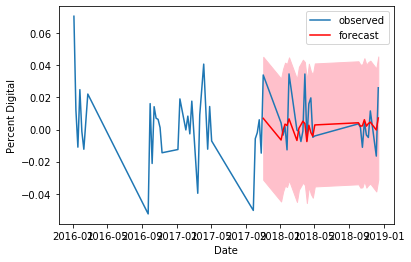

In [50]:
plt.figure()

plt.plot(df_ss_ARMAX_train.index, df_ss_ARMAX_train, label='observed')

#plot predictions
plt.plot(mean_forecast.index,
         mean_forecast,
         color='red',
         label='forecast')

# shade uncertainty area
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

plt.xlabel('Date')
plt.ylabel('Percent Digital')
plt.legend()

plt.show()

In [57]:
# Dynamic Predictions

results = model.fit()

forecast = results.get_prediction(start=-25, dynamic=True)

mean_forecast = forecast.predicted_mean

confidence_intervals = forecast.conf_int()

lower_limits = confidence_intervals.loc[:,'lower Percent_Digital_Viewership']
upper_limits = confidence_intervals.loc[:,'upper Percent_Digital_Viewership']

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


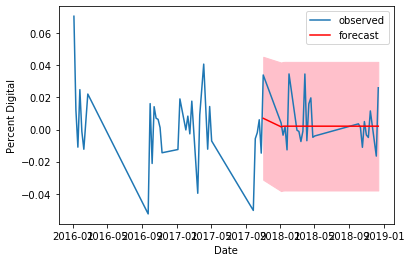

In [58]:
plt.figure()

plt.plot(df_ss_ARMAX_train.index, df_ss_ARMAX_train, label='observed')

#plot predictions
plt.plot(mean_forecast.index,
         mean_forecast,
         color='red',
         label='forecast')

# shade uncertainty area
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

plt.xlabel('Date')
plt.ylabel('Percent Digital')
plt.legend()

plt.show()

In [56]:
# Forecasting out of sample

forecast = results.get_forecast(steps=20)

mean_forecast = forecast.predicted_mean

confidence_intervals = forecast.conf_int()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
